# Messtechnik HS2021 - Tutorial 2

## Aufgabe 1: Linearität in der Spektroskopie
---------
Die Impulseantwort eines Spinsystems in der NMR/EPR kann durch die Blochgleichungen beschrieben werden. In der Annahme des Steady-States (wie z.B. bei continous wave EPR) ist das resultierende Spektrum durch die folgenden Parameter charakterisiert:

Frequenz $\nu$ , longitudinale Relaxationszeit $T_1$, transversale Relaxationszeit $T_2$ und die Anregungsstärke $\nu_1$.

Nehmen Sie für diese Aufgabe an, dass das System sich linear verhält (d.h. die Anregungsstärke klein ist).

---------

### 1a)
Erstellen sie ein Spektrum (Absorptions- und Dispersionsspektrum) im Frequenzbreich $[-10,10]$, welches zwei unterschiedliche Frequenzkomponenten beinhaltet. Die beiden Komponenten sind charakterisiert durch:

Komponente A
- $\nu_A   = 4$
- $T_{1,A} = 10$
- $T_{2,A} = 1$

Komponente B
- $\nu_B   = -2$
- $T_{1,B} = 20$
- $T_{2,B} = 1.5$

70% der angeregten Spins tragen zu Komponente A bei und 30% zu B.
Verwenden Sie die Funktion `Bloch_stationary()` aus den Modul `Bloch.py` um das Spekrum zu plotten.


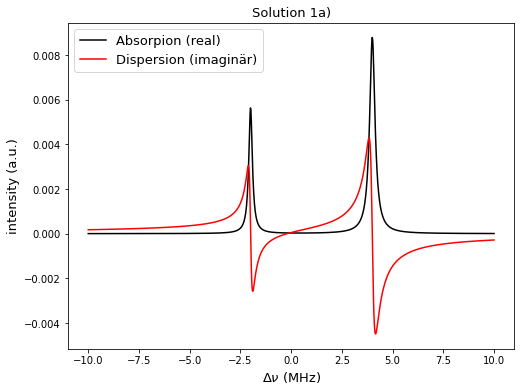

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from Bloch import Bloch_stationary

# Konstruiere Frequenzachse
frq_axis = np.linspace(-10,10,1024)

# Komponente A
frq_A  = 4
T1_A   = 10
T2_A   = 1
frac_A = 0.7

# Komponente B
frq_B  = -2
T1_B   = 20
T2_B   = 1.5
frac_B = 0.3

spc_A = Bloch_stationary(frq_axis,frq_A,T1_A,T2_A)
spc_B = Bloch_stationary(frq_axis,frq_B,T1_B,T2_B)

spc   = frac_A*spc_A + frac_B*spc_B # Annahme der Linearität, Einzelspektren können aufsummiert werden

# Plot
plt.figure(figsize=(8,6))
plt.plot(frq_axis,np.real(spc),'k')
plt.plot(frq_axis,np.imag(spc),'r')
plt.xlabel('$\Delta\\nu$ (MHz)',fontsize=13)
plt.ylabel('intensity (a.u.)',fontsize=13)
plt.legend(['Absorpion (real)','Dispersion (imaginär)'],fontsize=13)
plt.title('Solution 1a)',fontsize=13);

### 1b)
Berechnen Sie das Amplitudenverhältnis der beiden Spektralkomponenten und kommentieren Sie das Ergebnis. Weshalb entspricht es nicht dem Verhältnis der angeregten Spins?

Das Verhältnis der unterschiedlichen Komponenten widerspiegelt sich nicht in den Amplituden, sondern in den integralen Intensitäten ($7/3 \approx 2.33$). Hier ist die Linie mit dem grösseren Anteil breiter als diejenige mit dem kleineren Anteil. Daher ist das Amplitudenverhältnis kleiner ($\approx 1.56$).

In [70]:
maxA  = np.amax(np.real(frac_A*spc_A))
maxB  = np.amax(np.real(frac_B*spc_B))
ratio = maxA/maxB
ratio

1.5623344743932452

### 1c)
Schreiben Sie eine Funktion `Bloch_stationary_multiline()`, die als Input Listen von Parametern akzeptiert und so ein Mehrlinienspektrum berechnet. Testen Sie Ihre geschriebene Funktion mit den unten angegebenen Parametern.
 *Hinweis:* Ein `for`-loop kann sehr hilfreich sein.

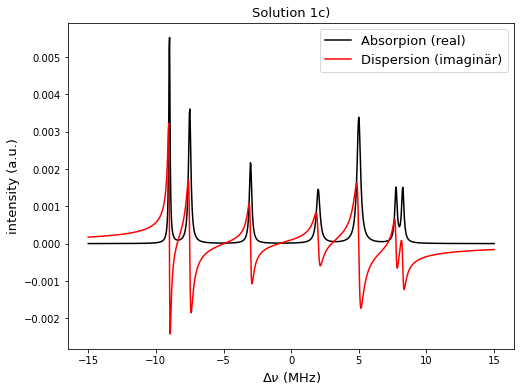

In [71]:
import numpy as np
import matplotlib.pyplot as plt 

def Bloch_stationary_multiline(frq_axis,frq,T1,T2,fraction):
    N = len(frq)
    spectrum = np.zeros_like(frq_axis)
    for i in range(N):
        currspc = Bloch_stationary(frq_axis,frq[i],T1[i],T2[i])
        spectrum = spectrum + fraction[i]*currspc
    return spectrum

# specify spectrum as line list
frq = [-9, -7.5, -3,2, 5, 7.75, 8.25]
T1  = [10, 12, 15, 10, 10, 20, 20]
T2  = [3, 1.5, 1.5, 1, 1, 1.5, 1.5]
fraction = [4, 5, 3, 3, 7, 2, 2]

# define the frequency axis
frq_axis = np.linspace(-15,15,1024)

# normalization
fraction = fraction/np.sum(fraction) 

# spectrum calculation
spc = Bloch_stationary_multiline(frq_axis,frq,T1,T2,fraction)

plt.figure(figsize=(8,6))
plt.plot(frq_axis,np.real(spc),'k')
plt.plot(frq_axis,np.imag(spc),'r')
plt.xlabel('$\Delta\\nu$ (MHz)',fontsize=13)
plt.ylabel('intensity (a.u.)',fontsize=13)
plt.legend(['Absorpion (real)','Dispersion (imaginär)'],fontsize=13)
plt.title('Solution 1c)',fontsize=13);

## Aufgabe 2: Lineares Verhalten vs. Nicht-lineares Verhalten / Sättigung
---------
Der Sättigungsparameter $S = (2\pi \nu_1)^2 T_1 T_2 $ beschreibt, ob ein Spinübergang als lineares System betrachtet werden kann. Um eine Abweichung vom linearen Verhalten zu erkennen muss die Abhängigkeit der Amplitude, integralen Intensität und der Linienform einer Spektralkomponente von der Anregungsstärke $\nu_1$ betrachet werden.

---------

### 2a)
Schreiben Sie eine Funktion, welche die maximale Amplitude, die integrale Intensität und die Linienform anhand der Full-Width-Half-Maximum (FWHM) für unterschiedliche Anregungsstärken $\nu_1$ berechnet. Teste deine Funktion mit den unten angegebenen Spinsystem-Parametern ($\nu,T_1,T_2$) für Anregungstärken $\nu_1 = [0.0001,0.1]$.
*Hinweis:* Um ein Integral zu berechnen können Sie die Numpy-Funktion `np.trapz` verwenden.

In [72]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
from Bloch import Bloch_stationary

def Bloch_saturation(frq_axis,frq,T1,T2,nu1):
    amplitude = np.zeros_like(nu1)
    integral  = np.zeros_like(nu1)
    fwhm      = np.zeros_like(nu1)

    for i in range(len(nu1)):
        currnu       = nu1[i]
        currspc      = Bloch_stationary(frq_axis,frq,T1,T2,currnu)
        amplitude[i] = np.amax(np.real(currspc))
        integral[i]  = np.trapz(np.real(currspc))
        halfmax      = np.amax(np.real(currspc))/2
        idx_max      = np.nonzero(np.real(currspc) == np.amax(np.real(currspc)))[0][0]
        spc_low      = np.real(currspc[0:idx_max])
        spc_high     = np.real(currspc[idx_max+1:len(currspc)])
        fwhm_low     = np.abs(spc_low - halfmax).argmin()
        fwhm_high    = np.abs(spc_high - halfmax).argmin()
        fwhm[i]      = frq_axis[fwhm_high+idx_max] - frq_axis[fwhm_low]
    return amplitude,integral,fwhm

# Spinsystem Parameter
frq_axis = np.linspace(-5,5,8192)
frq = 0
T1  = 10
T2  = 1

# Teste Bloch_saturation Funktion
nu1 = np.linspace(0.0001,0.1,2048)
amplitude,integral,fwhm = Bloch_saturation(frq_axis,frq,T1,T2,nu1)

### 2b)
Plotten Sie die maximale Amplitude, die integrale Intensität und die Full-Width-Half-Maximum (FWHM) in Abhänigkeit von der Anregungsstärke $\nu_1$ und dem Sättigungsparameter $S$. Überlegen Sie sich anhand dieser Plots in welchem Bereich von $\nu_1$ und $S$ das Spinsystem als linear betrachtet werden kann. Wie verhalten sich die maximale Amplitude, die integrale Intensität und die FWHM unterschiedlich im linearen und nicht-linearen Bereich?

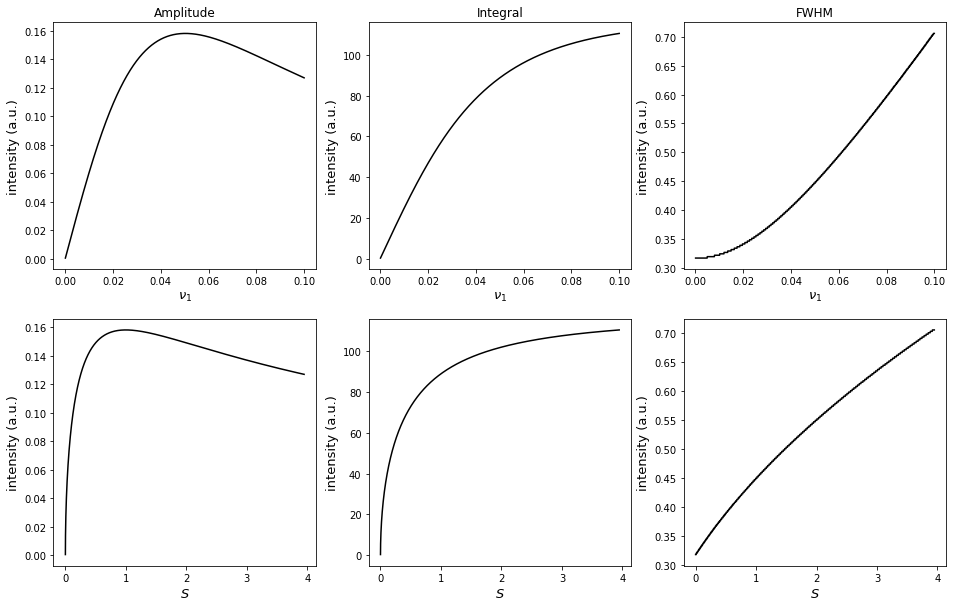

In [73]:
S = ((2*m.pi*nu1)**2)*T1*T2

plt.figure(figsize=(16,10))

# Plot maximale Amplitude
plt.subplot(231)
plt.plot(nu1,amplitude,'k')
plt.xlabel('$\\nu_1$',fontsize=13)
plt.ylabel('intensity (a.u.)',fontsize=13)
plt.title('Amplitude')
plt.subplot(234)
plt.plot(S,amplitude,'k')
plt.xlabel('$S$',fontsize=13)
plt.ylabel('intensity (a.u.)',fontsize=13)

# Plot integral Intensität
plt.subplot(232)
plt.plot(nu1,integral,'k')
plt.xlabel('$\\nu_1$',fontsize=13)
plt.ylabel('intensity (a.u.)',fontsize=13)
plt.title('Integral')
plt.subplot(235)
plt.plot(S,integral,'k')
plt.xlabel('$S$',fontsize=13)
plt.ylabel('intensity (a.u.)',fontsize=13)

# Plot FWHM
plt.subplot(233)
plt.plot(nu1,fwhm,'k')
plt.xlabel('$\\nu_1$',fontsize=13)
plt.ylabel('intensity (a.u.)',fontsize=13)
plt.title('FWHM')
plt.subplot(236)
plt.plot(S,fwhm,'k')
plt.xlabel('$S$',fontsize=13)
plt.ylabel('intensity (a.u.)',fontsize=13);

### 2c)
Bestimmen Sie die Steigungen der Amplitude und der integralen Intensität im linearen Bereich als Funktion von $\nu_1$:

- $ A_{\text{max}}(\nu_1) = c_1 \nu_1 $
- $ I(\nu_1) \; \; \; \; \; \;= c_2 \nu_1 $

Plotten Sie die Abhängigkeit der Amplitude und integralen Intensität von der Anregungsstärke $\nu1_1$ zusammen mit der linearen Approximation.
Berechnen und plotten Sie das Verhältnis zwischen der tatsächlichen und linear approximierten Amplitude / integralen Intensität ($A_{\text{real}}/A_{\text{lin}}$ und $I_{\text{real}}/I_{\text{lin}}$) in Abhänigkeit von $\nu_1$ und $S$.

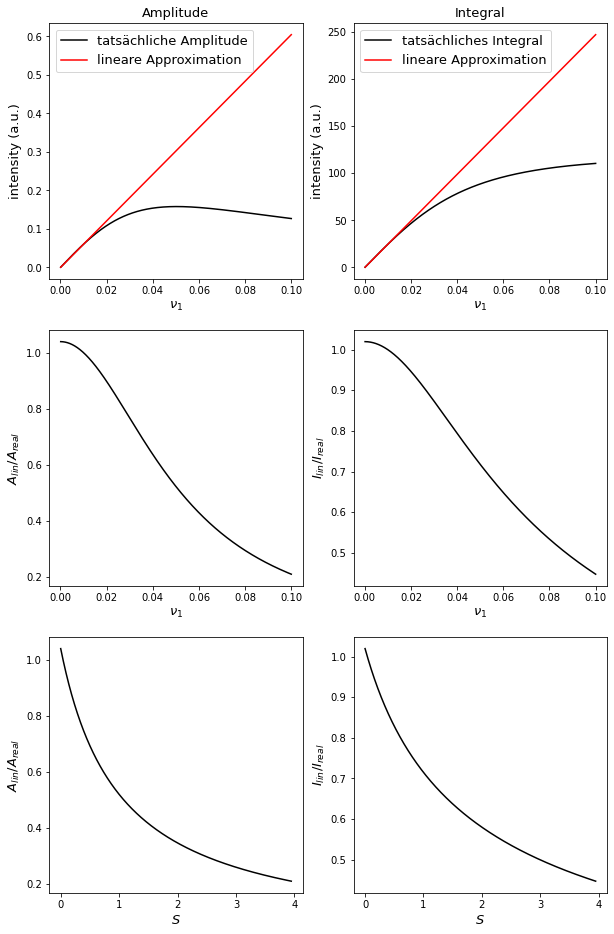

In [76]:
linlim  = 0.01
idx_lim = np.abs(nu1-linlim).argmin()
c1 = amplitude[idx_lim]/nu1[idx_lim]
c2 = integral[idx_lim]/nu1[idx_lim]

amplitude_lin = c1*nu1
integral_lin  = c2*nu1

Aratio = amplitude/amplitude_lin
Iratio = integral/integral_lin

plt.figure(figsize=(10,16))

# Plot maximale Amplitude
plt.subplot(321)
plt.plot(nu1,amplitude,'k')
plt.plot(nu1,amplitude_lin,'r')
plt.xlabel('$\\nu_1$',fontsize=13)
plt.ylabel('intensity (a.u.)',fontsize=13)
plt.legend(['tatsächliche Amplitude','lineare Approximation'],fontsize=13)
plt.title('Amplitude',fontsize=13)
plt.subplot(323)
plt.plot(nu1,Aratio,'k')
plt.xlabel('$\\nu_1$',fontsize=13)
plt.ylabel('$A_{lin}/A_{real}$',fontsize=13)
plt.subplot(325)
plt.plot(S,Aratio,'k')
plt.xlabel('$S$',fontsize=13)
plt.ylabel('$A_{lin}/A_{real}$',fontsize=13)

# Plot integral Intensität
plt.subplot(322)
plt.plot(nu1,integral,'k')
plt.plot(nu1,integral_lin,'r')
plt.xlabel('$\\nu_1$',fontsize=13)
plt.ylabel('intensity (a.u.)',fontsize=13)
plt.legend(['tatsächliches Integral','lineare Approximation'],fontsize=13)
plt.title('Integral',fontsize=13)
plt.subplot(324)
plt.plot(nu1,Iratio,'k')
plt.xlabel('$\\nu_1$',fontsize=13)
plt.ylabel('$I_{lin}/I_{real}$',fontsize=13)
plt.subplot(326)
plt.plot(S,Iratio,'k')
plt.xlabel('$S$',fontsize=13)
plt.ylabel('$I_{lin}/I_{real}$',fontsize=13);

